In [3]:
import numpy as np
import astropy
from astropy.io import ascii
from astropy.table import Table
import scipy.linalg as la
import pandas as pd
import requests
import uncertainties
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u
import json
import os
from scipy.optimize import curve_fit
import time


In [4]:
from uncertainties import unumpy as unp


In [5]:
from matplotlib import rc
# Default properties:
# rc('text', usetex=True)
rc('font', family='serif')
#rc('font', serif='palatino')
#rc('font', weight='bolder')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=2)
rc("lines", linewidth=3)
rc('axes', labelsize=30)
rc("axes", linewidth=2)
rc('xtick', labelsize=28)
rc('ytick', labelsize=28)
rc('legend', fontsize=20)
rc('xtick.major', pad=8)
rc('ytick.major', pad=8)
rc('xtick.major', size=13)
rc('ytick.major', size=13)
rc('xtick.major', width=3)
rc('ytick.major', width=3)
rc('xtick.minor', size=7)
rc('ytick.minor', size=7)
rc('xtick.minor', width=3)
rc('ytick.minor', width=3)


In [6]:
header = ["Exclusion Code",
          "D",
          "G",
          "Galaxy ID",
          "m-M",
          "err",
          "D (Mpc)",
          "Method",
          "REFCODE",
          "SN ID",
          "redshift (z)",
          "Hubble const.",
          "Adopted LMC modulus",
          "Date (Yr. - 1980)",
          "Notes"]
ned_data = pd.read_csv("./NED30.5.1-D-17.1.2-20200415.csv",
                       names=header, skiprows=13)


In [7]:
def getGalInfo(galname):
    # res_headers = {
    #     'Content-type': 'application/json',
    # }
    res_data = {
        'json': '{"name":{"v": "%s"}}' % galname
    }
    res = requests.post(
        'https://ned.ipac.caltech.edu/srs/ObjectLookup', data=res_data)
    return res.json()


In [8]:
def mod2dist(distance_modulus):
    return 10**(distance_modulus / 5)*10 / 1e6  # in unit Mpc


In [9]:
trgb_method = ned_data[ned_data["Method"] == "TRGB"]


In [10]:
if not os.path.exists('./trgb_reshift.json'):
    trgb_host_info = {}
    for index, row in trgb_method.iterrows():
        try:
            gal_info = getGalInfo(row["Galaxy ID"])["Preferred"]
        except:
            print(row["Galaxy ID"], "no data")
            continue
        redshift = gal_info["Redshift"]["Value"]
        z_err = gal_info["Redshift"]["Uncertainty"]
        paper_reference = gal_info["Redshift"]["RefCode"]
        if redshift is None:
            print(row["Galaxy ID"], " redshift is null")
            continue
        trgb_host_info[row["Galaxy ID"]] = (redshift, z_err, paper_reference)
        time.sleep(1)
    with open("trgb_reshift.json", "w") as fout:
        json.dump(trgb_host_info, fout)
else:
    with open("./trgb_reshift.json", "r") as fread:
        trgb_host_info = json.load(fread)


In [11]:
# plt.figure(figsize=(8, 6))
trgb_d = []
trgb_vr = []
trgb_err_vr = []
trgb_err_d = []
max_paper = None
max_num = 0
for paper in trgb_method['REFCODE']:
    if max_num < sum(trgb_method['REFCODE'] == paper):
        max_num = sum(trgb_method['REFCODE'] == paper)
        max_paper = paper
trgb_method_paper = trgb_method[trgb_method['REFCODE'] == max_paper]
# print(max)
for index, row in trgb_method_paper.iterrows():
    # print(bh_host_info[row["Galaxy ID"]][0])
    # if 3.35 < row["D (Mpc)"] and  row["D (Mpc)"] < 3.8:
    #     continue
    if row["Galaxy ID"] not in trgb_host_info.keys():
        # print("not plot %s" % row["Galaxy ID"])
        continue
    # 3 sigma cut
    if trgb_host_info[row["Galaxy ID"]][0] < 3 * trgb_host_info[row["Galaxy ID"]][1]:
        # print(index, row["Galaxy ID"], "rejected by 3 sigma cut")
        continue
    # if row["D (Mpc)"] < 10 and (const.c.to(u.km/u.s) * trgb_host_info[row["Galaxy ID"]][0]).value > 3000:
        # print(row)
        # print(trgb_host_info[row["Galaxy ID"]][0], trgb_host_info[row["Galaxy ID"]][1], trgb_host_info[row["Galaxy ID"]][2])
    u_dist = mod2dist(unp.uarray(row["m-M"], row["err"]))
    trgb_d.append(u_dist.n)
    trgb_err_d.append(u_dist.s)
    trgb_vr.append(const.c.to(u.km/u.s) * trgb_host_info[row["Galaxy ID"]][0])
    trgb_err_vr.append(const.c.to(u.km/u.s) *
                       trgb_host_info[row["Galaxy ID"]][1])
trgb_d = np.array(trgb_d)
trgb_err_d = np.array(trgb_err_d)
trgb_vr = np.array([i.value for i in trgb_vr])
trgb_err_vr = np.array([i.value for i in trgb_err_vr])
# plt.ylim([0, 2e3])


In [94]:
def hubble(d, H0):
    return H0 * d

def inv_hubble(v, H0):
    return v / H0

[90.6113409] [[13.27771115]]


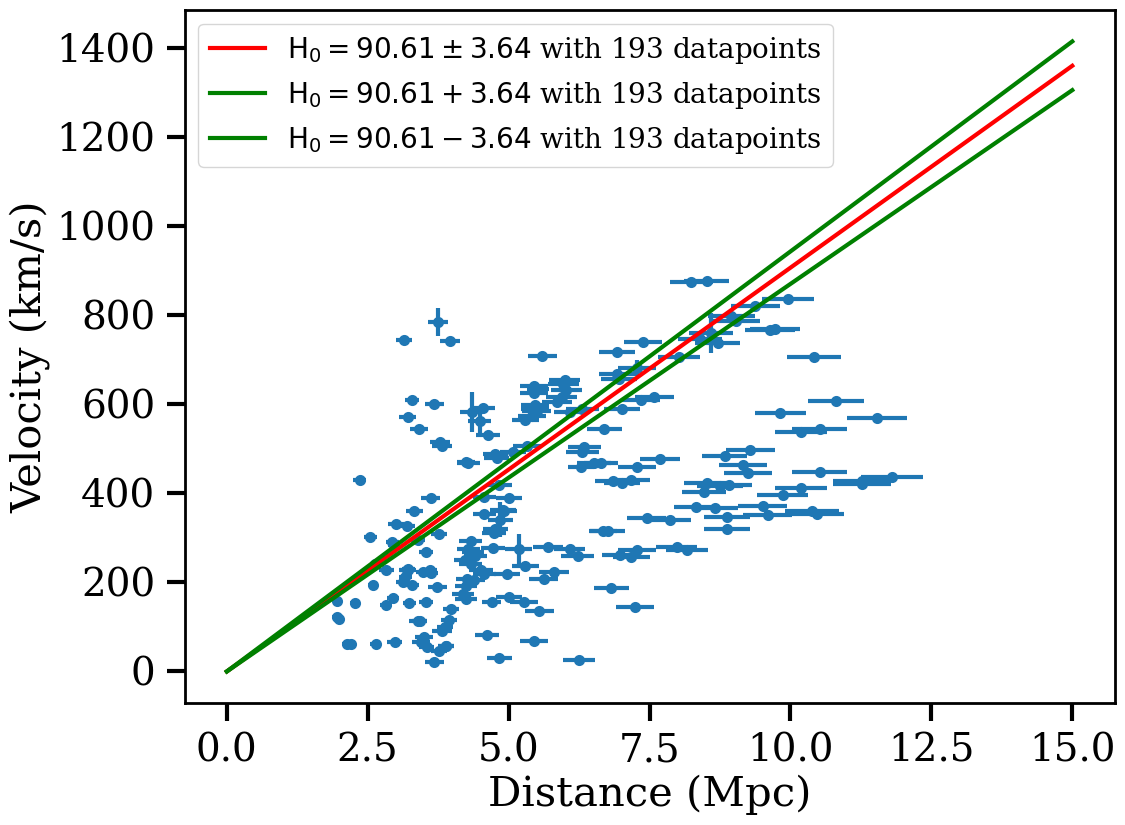

In [103]:
remove_value = (trgb_vr > 1.5e3) | (trgb_d > 15)
dist_cut = (trgb_d > 3 * trgb_err_d)
z_cut = (trgb_vr > 3 * trgb_err_vr)
mask = (trgb_d > 1.5) & ~remove_value & dist_cut & z_cut
trgb_popt, trgb_pcov = curve_fit(inv_hubble, trgb_vr[mask], trgb_d[mask], sigma=trgb_err_d[mask])
print(trgb_popt, trgb_pcov)
plt.figure(figsize=(12, 9))
plt.errorbar(trgb_d[mask], trgb_vr[mask], fmt='o',
             yerr=trgb_err_vr[mask], xerr=trgb_err_d[mask])
xarr = np.linspace(0, 15)
plt.plot(xarr, trgb_popt * xarr, "r", label=r"$H_0=%.2f \pm %.2f$ with %s datapoints" %
         (trgb_popt, np.sqrt(trgb_pcov), sum(mask)), zorder=1e10)
plt.plot(xarr, (trgb_popt + np.sqrt(trgb_pcov[0])) * xarr, "g", label=r"$H_0=%.2f + %.2f$ with %s datapoints" %
         (trgb_popt, np.sqrt(trgb_pcov), sum(mask)), zorder=1e10)
plt.plot(xarr, (trgb_popt - np.sqrt(trgb_pcov[0])) * xarr, "g", label=r"$H_0=%.2f - %.2f$ with %s datapoints" %
         (trgb_popt, np.sqrt(trgb_pcov), sum(mask)), zorder=1e10)
plt.xlabel("Distance (Mpc)")
plt.ylabel("Velocity (km/s)")
plt.legend(loc="upper left")
# plt.xlim([0, 450])
# plt.ylim([0, 3000])
plt.show()
# plt.savefig("trbg_single_paper.pdf", bbox_inches="tight")


In [14]:
from hyperfit.linfit import LinFit

In [104]:
trgb_data, trgb_cov = np.empty((2, trgb_d[mask].shape[0])), np.empty((2, 2, trgb_d[mask].shape[0]))
for i, (x, y, ex, ey) in enumerate(zip(trgb_d[mask], trgb_vr[mask], trgb_err_d[mask], trgb_err_vr[mask])):
    trgb_data[:, i] = np.array([x, y])
    trgb_cov[:, :, i] = np.array([[ex**2, 0], [0, ey**2]])
# trgb_data = np.array([trgb_d[mask], trgb_vr[mask]])
# trgb_cov = np.array([[[trgb_err_d[mask][i]**2, 0], [0, trgb_err_vr[mask][i]**2]] for i in range(len(trgb_d[mask]))]).T

In [105]:
hf = LinFit(trgb_data, trgb_cov)  

In [114]:
bounds = ((-1e-2, 100), (-1e-2, 3000), (1e-5, 1000))
params, sigma_y, loglike = hf.optimize(bounds=bounds)

In [110]:
mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

     fun: array([286.59863166])
     jac: array([-3.76866069e+01, -1.64836933e+02, -1.66437531e-02])
 message: 'Optimization terminated successfully.'
    nfev: 6577
     nit: 144
 success: True
       x: array([ 4.99999976e-03, -6.39896384e-05,  2.65373662e+00])


100%|██████████| 1000/1000 [00:00<00:00, 1494.88it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [72.98141296 72.66816889 49.88733629] / 3649.0706481761736


100%|██████████| 1000/1000 [00:00<00:00, 1644.49it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [32.69368874 32.57130326 39.99488154] / 1999.7440770659964


100%|██████████| 1000/1000 [00:00<00:00, 1608.58it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [39.6566469  39.257742   38.55092345] / 1982.8323449591953


100%|██████████| 1000/1000 [00:00<00:00, 1598.80it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.88831707 44.44444875 38.14182893] / 2244.4158536372333


100%|██████████| 1000/1000 [00:00<00:00, 1519.05it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [49.18902334 48.63799476 41.71584535] / 2459.4511667749125


100%|██████████| 1000/1000 [00:00<00:00, 1421.29it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [53.95411681 53.50914509 43.2681597 ] / 2697.7058402767957


100%|██████████| 1000/1000 [00:00<00:00, 1613.92it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [54.98364748 54.7861953  45.58228102] / 2749.182373811973


100%|██████████| 1000/1000 [00:00<00:00, 1669.89it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [60.19149472 59.78619657 48.23162243] / 3009.574735943048


100%|██████████| 1000/1000 [00:00<00:00, 1670.55it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [57.95352011 57.81714795 47.18815064] / 2897.676005363007
[ 77.12385844   6.72167434 208.5587453 ] [ 2.74964638  4.86398835 12.94049843]


<Figure size 640x480 with 0 Axes>

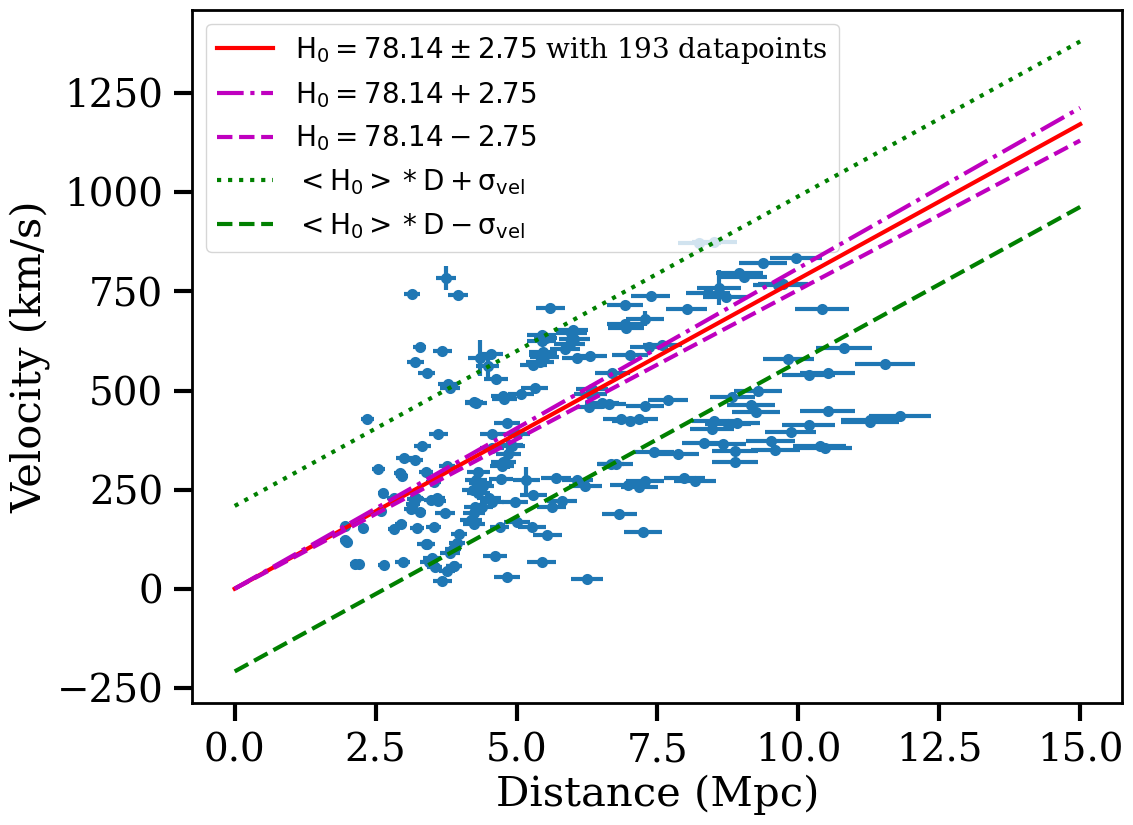

In [147]:
plt.figure(figsize=(12, 9))
plt.errorbar(trgb_d[mask], trgb_vr[mask], fmt='o',
             yerr=trgb_err_vr[mask], xerr=trgb_err_d[mask])
xarr = np.linspace(0, 15)
H0 = params[0]
H0_err = np.std(mcmc_samples, axis=1)[0]
plt.plot(xarr, H0 * xarr, "r", label=r"$H_0=%.2f \pm %.2f$ with %s datapoints" %
         (H0, H0_err, sum(mask)), zorder=1e10)
plt.plot(xarr, (H0 + H0_err) * xarr, "m-.", label=r"$H_0=%.2f + %.2f$" %
         (H0, H0_err), zorder=1e10)
plt.plot(xarr, (H0 - H0_err) * xarr, "m--", label=r"$H_0=%.2f - %.2f$" %
         (H0, H0_err), zorder=1e10)
plt.plot(xarr, H0 * xarr + sigma_y, "g:", label=r"$<H_0> * D + \sigma_{vel}$" %
         (sigma_y), zorder=1e10)
plt.plot(xarr, (H0) * xarr - sigma_y, "g--", label=r"$<H_0> * D - \sigma_{vel}$" %
         (sigma_y), zorder=1e10)
plt.xlabel("Distance (Mpc)")
plt.ylabel("Velocity (km/s)")
plt.legend(loc="upper left")
# plt.xlim([0, 450])
# plt.ylim([0, 3000])
plt.show()
plt.savefig("trbg_single_paper_hyperfit.pdf", bbox_inches="tight")


In [133]:
hf.vert_scat

208.8041162303801

In [21]:
trgb_data.shape

(2, 195)

In [22]:
cov.shape

NameError: name 'cov' is not defined

In [ ]:
trgb_cov = np.array([[[trgb_err_d[mask][i]**2, 0], [0, trgb_err_vr[mask][i]**2]] for i in range(len(trgb_d[mask]))]).T

In [ ]:
trgb_cov.shape

(2, 2, 171)